In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from scipy import stats
import missingno as msno
from sklearn import model_selection, preprocessing, linear_model, neighbors, ensemble, neural_network, metrics, impute, tree
from sklearn.feature_selection import SelectKBest, f_classif
from copy import deepcopy
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Polish companies Bankruptcy dataset

In this dataset, we have to predict which of the companies went bankrupt in the 3 years following an initial observation. Just like the Fertility dataset, this dataset is also heavily imbalanced: only 5% of companies went bankrupt while 95% of companies survived. 

The ratio variables contain very big outliers which have to be taken into account. 

The variables also have to be scaled because of the different ranges of the different variables. 

Additionally this dataset contains missing values. Overall ~1.5\% of the data is missing, but there is one feature that is missing almost 50\% of values. 

Also most of the ratio variables were synthetically generated (meaning they were constructed from some other, initial features by combining them with mathematical operations; those initial features are not present in the dataset directly).

## 1. Load Dataset

In [49]:
dataset_filepath = 'data/Polish_Banks/polish_banks_dataset.csv'
attribute_names_file_path = 'data/Polish_Banks/attr_names.pickle'

In [94]:
df = pd.read_csv(dataset_filepath)
with open(attribute_names_file_path, 'rb') as f:
    attr_names = pickle.load(f)

# replace with more descriptive names
df['class'].replace({'b\'0\'': 'Not bankrupt', 'b\'1\'': 'Bankrupt'}, inplace=True)
random_state = 244

## 2. Dataset Exploration

### 2.1 Datatypes
We can see that all of our features are of type 'float64'. The only column with a different type is the class column, which is our classification target. It indicates whether the sample went bankrupt or not. 

,class
0,Not bankrupt
1,Not bankrupt
2,Not bankrupt
3,Not bankrupt
4,Not bankrupt
...,...
10498,Bankrupt
10499,Bankrupt
10500,Bankrupt
10501,Bankrupt


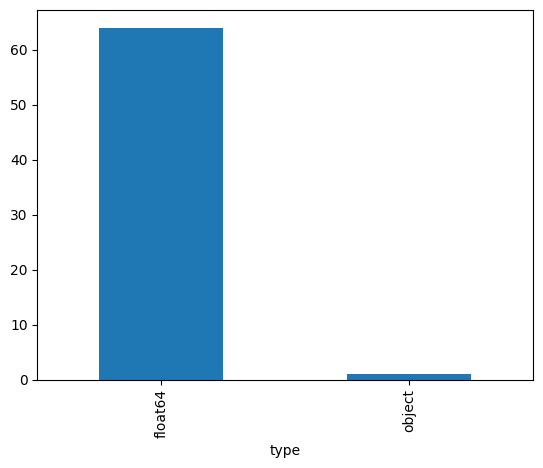

In [95]:
datatypes = pd.DataFrame(df.dtypes, columns=["type"]).reset_index()
datatypes.groupby("type").count().plot(kind='bar', legend=False)
object_values = datatypes[datatypes["type"] == "object"]["index"].values
display(df[object_values])
non_object_values = datatypes[datatypes["type"] != "object"]["index"].values

### 2.2 Unique values
We can see that the attribute with the least unique values still has 5000 and those values are still continous.

In [96]:
def plot_hist(df, attr_name):
    _, ax = plt.subplots(figsize=(8,4))
    sns.despine()
    plot = sns.histplot(data=df, x=attr_name)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel(attr_names[attr_name], fontsize=12)
def plot_kde(df, attr_name):
    _, ax = plt.subplots(figsize=(8,4))
    sns.despine()
    plot = sns.kdeplot(data=df, x=attr_name)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_xlabel(attr_names[attr_name], fontsize=12)

In [97]:
display(df.nunique().sort_values())
display(df['Attr59'])

class         2
Attr59     5555
Attr37     5558
Attr6      5864
Attr21     7962
          ...  
Attr40    10032
Attr16    10039
Attr12    10080
Attr55    10156
Attr5     10186
Length: 65, dtype: int64

0        0.000007
1        0.000000
2        0.000000
3        0.142980
4        0.073039
           ...   
10498    0.327360
10499    1.153000
10500    0.814200
10501    0.000000
10502    2.398500
Name: Attr59, Length: 10503, dtype: float64

## 2.3 Value ranges
We have very different scales for the attributes -> we definitely have to do normalization for the methods that require it. Min-max scaling is definitely not the way to go as can be seen in the boxplot: Very high values have a very low probability of happening. Those generally seem to be very huge outliers (-11903000 for a row that mostly has values between -3000 to 3000), so it might be the case that some of the rows were entered wrongly. 

We can also see that only by removing the maximum for Attribute5 mean and std are changed massively. This will also have a huge impact on standardization based on the z-score. Hence choosing the robustScaler might be preferable.

Attr29    9.978430e+00
Attr35    6.467000e+01
Attr48    6.528900e+01
Attr22    6.528900e+01
Attr14    7.034400e+01
              ...     
Attr60    3.660200e+06
Attr55    4.131880e+06
Attr32    6.683496e+06
Attr15    1.255780e+07
Attr5     1.258844e+07
Length: 64, dtype: float64

,count,mean,std,min,25%,50%,75%,max
Attr1,10503.0,0.052844,0.647797,-1.769200e+01,0.000686,0.043034,0.123805,52.652
Attr2,10503.0,0.619911,6.427041,0.000000e+00,0.253955,0.464140,0.689330,480.730
Attr3,10503.0,0.095490,6.420056,-4.797300e+02,0.017461,0.198560,0.419545,17.708
Attr4,10485.0,9.980499,523.691951,2.080200e-03,1.040100,1.605600,2.959500,53433.000
Attr5,10478.0,-1347.662372,118580.569222,-1.190300e+07,-52.070750,1.579300,56.084000,685440.000
...,...,...,...,...,...,...,...,...
Attr60,9911.0,571.336309,37159.672255,0.000000e+00,5.533150,9.952100,20.936000,3660200.000
Attr61,10486.0,13.935361,83.704103,-6.590300e+00,4.486075,6.677300,10.587500,4470.400
Attr62,10460.0,135.536989,25991.162023,-2.336500e+06,40.737000,70.664000,118.220000,1073500.000
Attr63,10485.0,9.095149,31.419096,-1.562200e-04,3.062800,5.139200,8.882600,1974.500


'max = 685440.0 min = -11903000.0'

,count,mean,std,min,25%,50%,75%,max
Attr1,10502.0,0.052848,0.647828,-1.769200e+01,0.000684,0.043044,0.123808,52.652
Attr2,10502.0,0.619898,6.427347,0.000000e+00,0.253922,0.464110,0.689250,480.730
Attr3,10502.0,0.095489,6.420362,-4.797300e+02,0.017460,0.198600,0.419572,17.708
Attr4,10484.0,9.981340,523.716922,2.080200e-03,1.040075,1.605750,2.959550,53433.000
Attr5,10477.0,-211.683338,23239.728365,-1.670200e+06,-52.052000,1.584000,56.105000,685440.000
...,...,...,...,...,...,...,...,...
Attr60,9910.0,571.393620,37161.546817,0.000000e+00,5.534225,9.953750,20.937000,3660200.000
Attr61,10485.0,13.934696,83.708068,-6.590300e+00,4.485800,6.676300,10.586000,4470.400
Attr62,10459.0,135.539559,25992.404637,-2.336500e+06,40.735000,70.641000,118.230000,1073500.000
Attr63,10484.0,9.095696,31.420545,-1.562200e-04,3.062750,5.139400,8.883475,1974.500


-3214.6800000000003

3351.2259999999974

6565.905999999997

'10442, 10293, 10292.94'

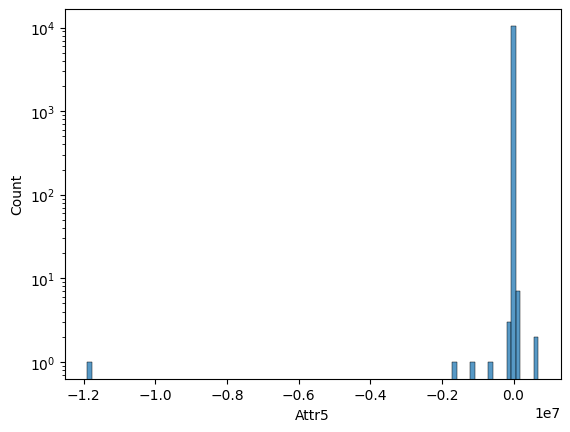

In [98]:
display((df.max(numeric_only=True)-df.min(numeric_only=True)).sort_values())
display(df.describe().T)
display(f"max = {df.Attr5.max()} min = {df.Attr5.min()}")
sns.histplot(data=df, x='Attr5', bins=100)
plt.yscale('log')
display(df[df.Attr5 != -11903000.0].describe().T)

Q1 = df.Attr5.quantile(0.01)
Q3 = df.Attr5.quantile(0.99)
IQR = Q3 - Q1
display(Q1, Q3, IQR)
condition = ~((df.Attr5 < (Q1 - 1.5 * IQR)) | (df.Attr5 > (Q3 + 1.5 * IQR)))
condition2 = ~((df.Attr5 < (Q1)) | (df.Attr5 > (Q3)))
display(f"{condition.sum()}, {condition2.sum()}, {len(condition)*0.98}")




### 2.4 Missing Values

One feature seems to be missing a huge amount of values -> easiest to just drop it. Others have most values -> imputation with knn might be worth considering?

'(current assets - inventories) / long-term liabilities'

<Figure size 640x480 with 0 Axes>

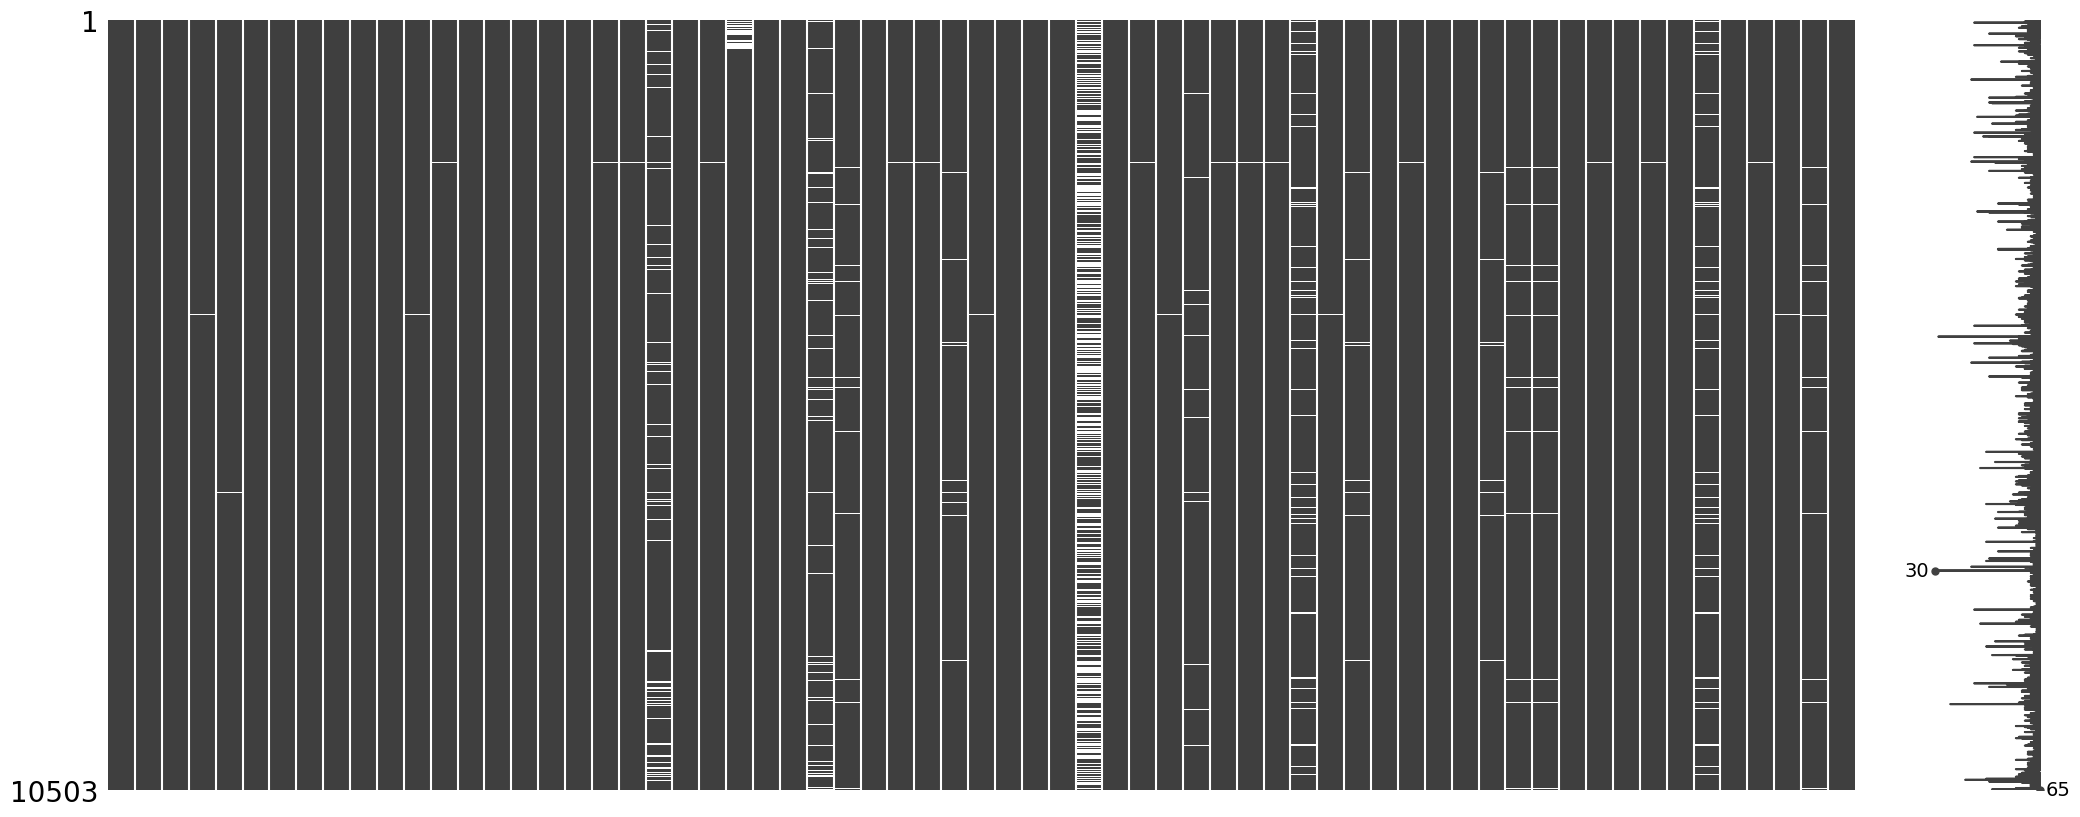

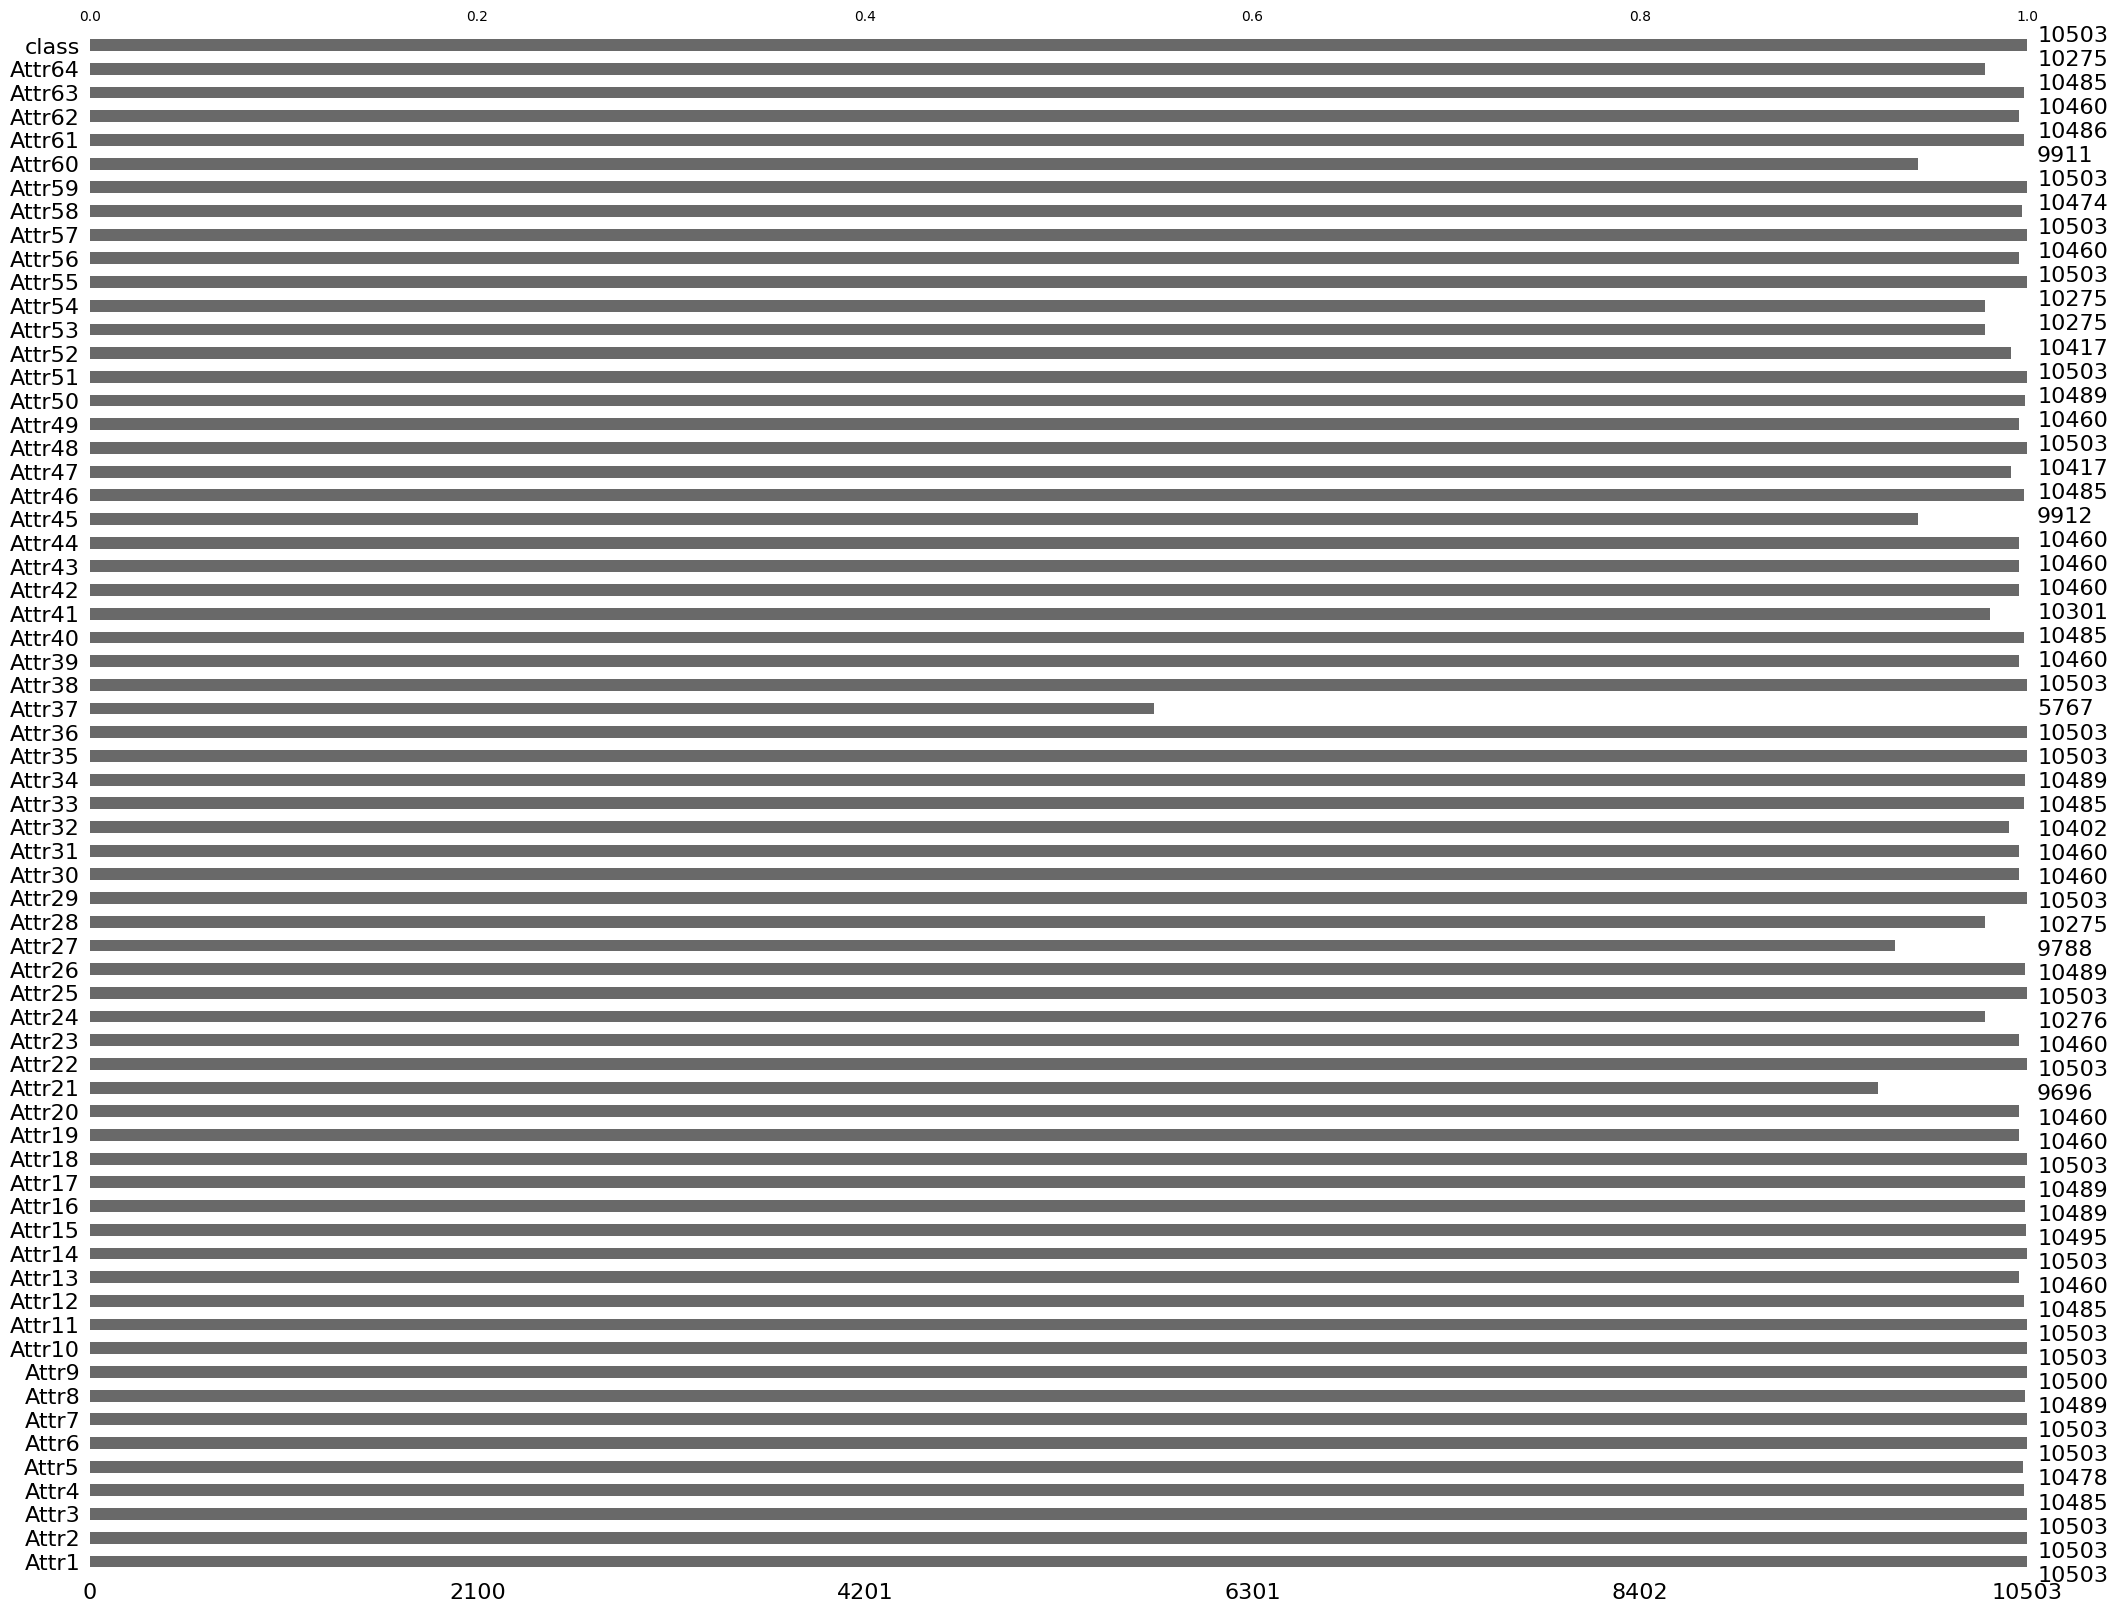

In [99]:
plt.figure()
msno.matrix(df)
plt.figure()
msno.bar(df)
attr_names['Attr37']

Some of the features have a missing value correlation of 1.0 (which means that if one of the features has a missing value then it is also always missing in the other feature). When looking at the attribute names, this makes sense as in those cases the formulas share atleast one common variable. In the cases when the coefficient is >=0.8 but <1.0 the variables are not identical but strongly related variables (e.q. total liabilities vs. short-term liabilities)

'profit on operating activities / sales'

'gross profit / sales'

'(gross profit + depreciation) / sales'

'(inventory * 365) / sales'

'net profit / sales'

'(total liabilities - cash) / sales'

'(gross profit + interest) / sales'

'profit on sales / sales'

<Figure size 640x480 with 0 Axes>

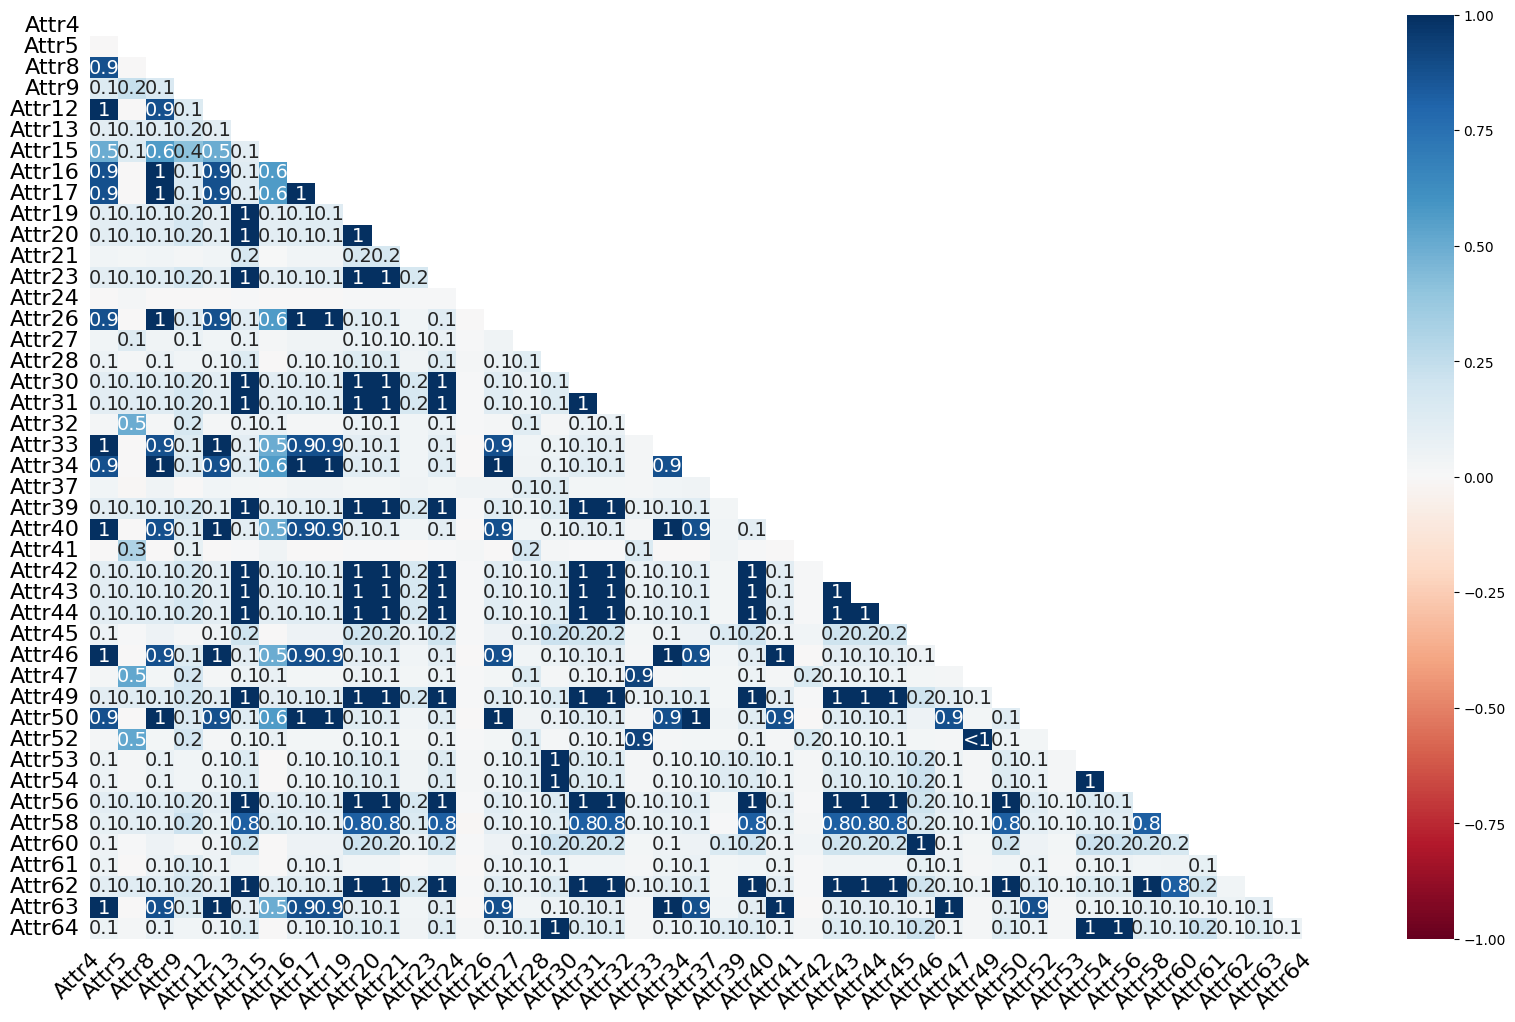

In [100]:
plt.figure()
msno.heatmap(df)
display(attr_names['Attr42'], attr_names['Attr19'], attr_names['Attr13'], attr_names['Attr20'], attr_names['Attr23'], attr_names['Attr30'], attr_names['Attr31'], attr_names['Attr39'])

In [101]:
# missing value correlation of 0.9
display(attr_names['Attr16'], attr_names['Attr4'])

'(gross profit + depreciation) / total liabilities'

'current assets / short-term liabilities'

In [102]:
# missing value correlation of 0.9
display(attr_names['Attr63'], attr_names['Attr8'])
# missing value correlation of 0.5
display(attr_names['Attr40'], attr_names['Attr15'])

'sales / short-term liabilities'

'book value of equity / total liabilities'

'(current assets - inventory - receivables) / short-term liabilities'

'(total liabilities * 365) / (gross profit + depreciation)'

After exlucing the attribute that has many missing values (which will be dropped later on), we can see that the majority of bankrupt companies have atleast one column with a missing value, while that is only the case for a minority of non-bankrupt companies. Thus it might be worth to create an artificial feature that indicates whether the row has a missing value or not.

In [103]:
bankrupt_at_least_1_null = df[df['class'] == 'Bankrupt'].drop('Attr37', axis=1).isnull().any(axis=1).sum()
bankrupt_no_nulls = df[df['class'] == 'Bankrupt'].drop('Attr37', axis=1).notnull().all(axis=1).sum()
not_bankrupt_at_least_1_null = df[df['class'] == 'Not bankrupt'].drop('Attr37', axis=1).isnull().any(axis=1).sum()
not_bankrupt_no_nulls = df[df['class'] == 'Not bankrupt'].drop('Attr37', axis=1).notnull().all(axis=1).sum()
display(f"Bankrupt null rows percentage: {bankrupt_at_least_1_null/(bankrupt_at_least_1_null+bankrupt_no_nulls)}")
display(f"Not bankrupt null rows percentage: {not_bankrupt_at_least_1_null/(not_bankrupt_at_least_1_null+not_bankrupt_no_nulls)}")

'Bankrupt null rows percentage: 0.6121212121212121'

'Not bankrupt null rows percentage: 0.19644284572342127'

Bankrupt and non-bankrupt companies seem too have they same amount of missing Attr37 values. Thus we will take the easiest option and just drop the column as we would have to impute half of the values for the column, which probably won't mork that well.

In [104]:
bankrupt_at_least_1_null = df[df['class'] == 'Bankrupt'].Attr37.isnull().sum()
bankrupt_no_nulls = df[df['class'] == 'Bankrupt'].Attr37.notnull().sum()
not_bankrupt_at_least_1_null = df[df['class'] == 'Not bankrupt'].Attr37.isnull().sum()
not_bankrupt_no_nulls = df[df['class'] == 'Not bankrupt'].Attr37.notnull().sum()
display(f"Bankrupt null rows percentage: {bankrupt_at_least_1_null/(bankrupt_at_least_1_null+bankrupt_no_nulls)}")
display(f"Not bankrupt null rows percentage: {not_bankrupt_at_least_1_null/(not_bankrupt_at_least_1_null+not_bankrupt_no_nulls)}")

'Bankrupt null rows percentage: 0.45454545454545453'

'Not bankrupt null rows percentage: 0.4507394084732214'

Most companies either don't have any missing values or are only missing one. It's very unlikely for a company/sample to have many missing values

Text(0.5, 1.0, 'Distribution of missing values per row for bankrupt companies')

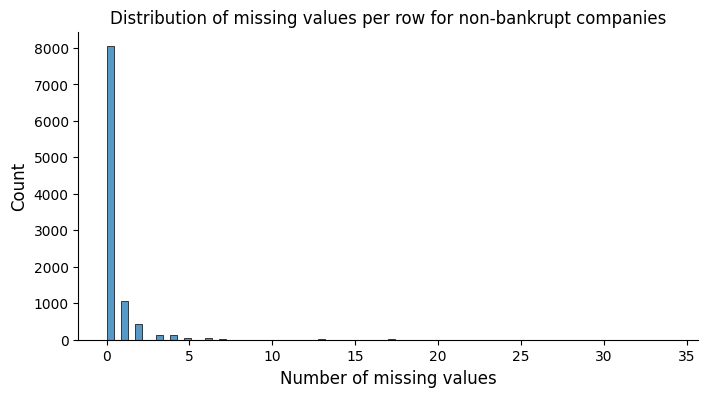

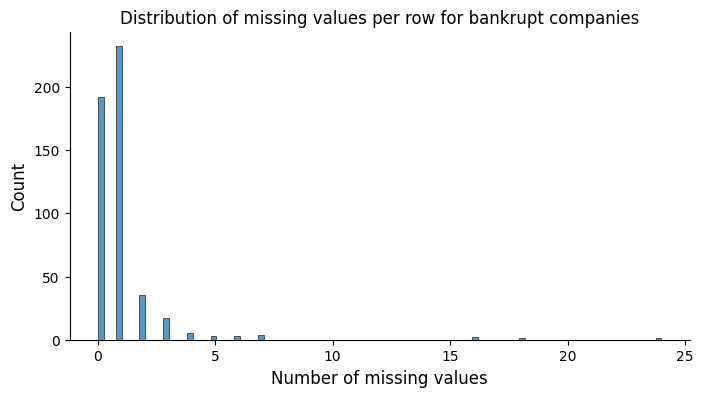

In [105]:
df_nb = df[df['class'] == 'Not bankrupt'].drop('Attr37', axis=1).isnull().sum(axis=1)
_, ax = plt.subplots(figsize=(8,4))
sns.despine()
plot = sns.histplot(data=df_nb, bins=80)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Number of missing values', fontsize=12)
ax.set_title('Distribution of missing values per row for non-bankrupt companies')

df_nb = df[df['class'] == 'Bankrupt'].drop('Attr37', axis=1).isnull().sum(axis=1)
_, ax = plt.subplots(figsize=(8,4))
sns.despine()
plot = sns.histplot(data=df_nb)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Number of missing values', fontsize=12)
ax.set_title('Distribution of missing values per row for bankrupt companies')

In [106]:
print(f"Percentage of missing values: {df.isnull().sum().sort_values().sum()/(df.shape[0] * (df.shape[1] - 1))* 100:.2f}%")

Percentage of missing values: 1.47%


### 2.5 Target value distribution
We have a heavily skewed dataset, which means that we will have to deal with it with some kind of strategy.

Text(0.5, 0, 'Percent')

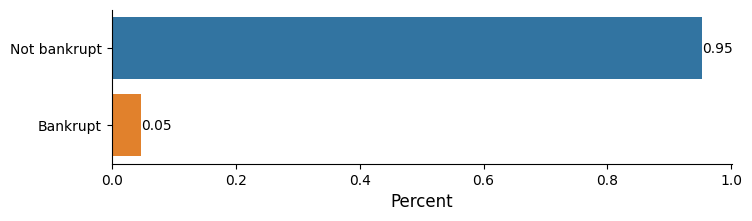

In [107]:
class_counts = df['class'].value_counts()/len(df['class'])
_, ax = plt.subplots(figsize=(8, 2))
sns.despine()
sns.barplot(x=class_counts.values, y=class_counts.index)
ax.bar_label(ax.containers[0], fmt='{:.2f}')
ax.set_xlabel('Percent', fontsize=12)

### 2.6 Correlation Matrix
We have some heaviliy correlated attributes, but nothing too crazy. Still feature selection to remove some highly correlated attributes might be worth.#

/tmp/ipykernel_33164/3288021558.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

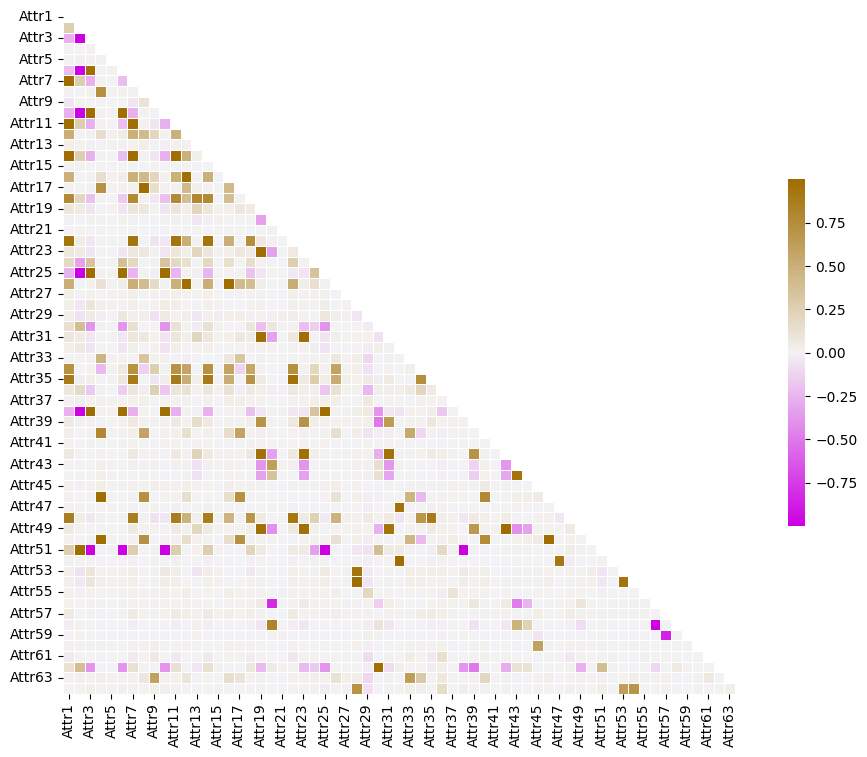

In [108]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(300, 50, s=100, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 3. Preprocessing
First we drop the column that had many missing values (Attr37). Also set some flags for the experiment that we want to run

In [109]:
df_proc = df.copy()
display(df_proc)
df_proc.drop('Attr37', inplace=True, axis=1)
do_outlier_removal = False
do_scaling = False
do_imputation = False               # TRUE: KNN imputer, FALSE: median imputation
do_resampling = False
do_feature_selection = False

do_holdout = False                  # FALSE: PERFORM CV
add_number_of_missing_values_feature = False

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.143710,1.34800,-28.9820,0.603830,0.219460,1.122500,1.19610,0.463590,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,Not bankrupt
1,0.146240,0.46038,0.282300,1.62940,2.5952,0.000000,0.171850,1.172100,1.60180,0.539620,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,Not bankrupt
2,0.000595,0.22612,0.488390,3.15990,84.8740,0.191140,0.004572,2.988100,1.00770,0.675660,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,Not bankrupt
3,0.024526,0.43236,0.275460,1.78330,-10.1050,0.569440,0.024526,1.305700,1.05090,0.564530,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,Not bankrupt
4,0.188290,0.41504,0.342310,1.92790,-58.2740,0.000000,0.233580,1.409400,1.33930,0.584960,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,Not bankrupt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10498,0.002861,0.58067,-0.223860,0.51658,-31.8660,0.002861,0.002861,0.618550,1.01200,0.359170,...,0.011834,0.007966,0.98817,0.327360,38.1420,39.1500,42.202,8.6489,5.2646,Bankrupt
10499,-0.051968,0.55254,0.147150,2.16980,12.7480,-0.051968,-0.034361,0.669830,0.94694,0.370110,...,-0.056037,-0.140410,1.05600,1.153000,14.4930,9.2851,32.761,11.1410,1.9276,Bankrupt
10500,-0.135900,0.83954,-0.342010,0.46526,-145.3100,-0.219120,-0.131860,0.191130,1.09990,0.160460,...,0.144120,-0.846930,0.85427,0.814200,6.2737,9.6966,212.230,1.7198,1.5659,Bankrupt
10501,0.009423,0.50028,0.261630,1.52300,-10.1580,0.009423,0.007700,0.989900,1.01230,0.495230,...,0.012186,0.019027,0.98781,0.000000,5.9675,4.3536,98.240,3.7154,7.8068,Bankrupt


## 3.1 Train/test split
As per the assignment description will we compare crossvalidation with holdout later on. Still we will have an independent test set for both cases, which will be used to compare both methods with each other. 
Depending on the experiment a new feature will be added that saves how many missing values each sample had before imputation.

In [110]:
if add_number_of_missing_values_feature:
    number_of_missing_values = df_proc.isnull().sum(axis=1)
    df_proc['numNull'] = number_of_missing_values
y = df_proc.pop('class')
X = df_proc
X_tr_h, X_test_h, y_tr_h, y_test_h = model_selection.train_test_split(X, y, test_size = 0.33, random_state = random_state, shuffle=True)

Depending on the experiment a very naive outlier removal will be done, which basically just removes all rows that have absolute values that are bigger than 1.5 of the IQR (which is defined as the value range between 0.02 and 0.98 of the values). Normally if one would have enough time for it a more manual approach would be preferable.

In [111]:

if do_outlier_removal:
    Q1 = X_tr_h.quantile(0.02) # Same as np.percentile but maps (0,1) and not (0,100)
    Q3 = X_tr_h.quantile(0.98)
    IQR = Q3 - Q1
    condition = ~((X_tr_h < (Q1 - 1.5 * IQR)) | (X_tr_h > (Q3 + 1.5 * IQR))).any(axis=1)
    X_tr_h = X_tr_h[condition]
    y_tr_h = y_tr_h[condition]


## 3.2 Scaling
RobustScaler is a scaler that scales according to median and quantiles, which is more robust against outliers than a z-score Scaler, hence it will be used for this dataset.

In [112]:
preprocessing_steps = []

if do_scaling:
    scaler = preprocessing.RobustScaler(unit_variance=True)
    #scaler = preprocessing.StandardScaler()
    preprocessing_steps.append(('robust_scaling', scaler))

## 3.3 Imputation
As a baseline we will simply replace all missing values with the median of the column (not average, as average is very sensitive to outliers). We will also try a more sophisticated approach which is based on KNN.

In [113]:
if do_imputation:
    imputer = impute.KNNImputer(n_neighbors=3, weights='distance')
    preprocessing_steps.append(('KNN_imputer', imputer))
else:
    imputer = impute.SimpleImputer(strategy='median')
    preprocessing_steps.append(('simple_imputer', imputer))


## 3.4 Feature selection
As we have some features that are highly correlated we will also look at the impact that feature selection might have on the results.

In [114]:
if do_feature_selection:
    anova_filter = SelectKBest(f_classif)
    preprocessing_steps.append(('KBest', anova_filter))

## 3.5 Oversampling
Unfortunately not all classifiers in sklearn support a class_weight argument (which would weight metrics that are important in training towards the minority class). Thus we will also look at over/undersampling strategies.

In [115]:
if do_resampling:
    sampler = SMOTE(k_neighbors=5)
    sampler = RandomOverSampler(random_state=random_state, sampling_strategy='not majority')
    preprocessing_steps.append(('Resampler', sampler))
    class_weights = None
else:
    bankrupt_count = (y_tr_h == 'Bankrupt').sum()
    not_bankrupt_count = y_tr_h.shape - bankrupt_count
    bankrupt_weight = y_tr_h.shape/(2*bankrupt_count)
    not_bankrupt_weight = y_tr_h.shape/(2*not_bankrupt_count)
    class_weights = {'Bankrupt': bankrupt_weight, 'Not bankrupt': not_bankrupt_weight}
    class_weights

## 4 Modelling

### 4.1 Classifiers
We will focus on KNN, MLP and DecisionTrees, as those are three very different classifiers, with different strengths, weaknesses and are from different "paradigms".

In [116]:
pipelines = {}
methods = [
    ('RidgeClassifier', linear_model.RidgeClassifier(class_weight=class_weights)), 
    ('KNN', neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')), 
    ('RandomForests', ensemble.RandomForestClassifier(class_weight=class_weights)), 
    ('Perceptron', linear_model.Perceptron(class_weight=class_weights)),
    ('MLP', neural_network.MLPClassifier(random_state=random_state)),
    ('Tree', tree.DecisionTreeClassifier(class_weight=class_weights, random_state=random_state))]

for method in methods:
    pipeline_steps = deepcopy(preprocessing_steps)
    pipeline_steps.append(method)
    pipeline = Pipeline(pipeline_steps)
    name, cl = method
    pipelines[name] = pipeline

We will do either 5-fold CV for hyperparameter tuning or split the training set into training + validation set (holdout method), where the validation set stays the same.

In [117]:
def perform_gridsearch(pipe, params):
    if do_holdout:
        X_train, X_val, y_train, y_val = model_selection.train_test_split(X_tr_h, y_tr_h, random_state=random_state+1, test_size=0.2)
        tr_val_split = y_tr_h.copy()
        tr_val_split[:] = 0
        tr_val_split[X_train.index.values] = -1
        cv = model_selection.PredefinedSplit(tr_val_split)
    else:
        cv = 5
    gr_search = model_selection.GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1)
    gr_search.fit(X_tr_h, y_tr_h)
    best_params = gr_search.best_params_
    best_score = gr_search.best_score_
    best_model_train_time = gr_search.refit_time_

    best_model = gr_search.best_estimator_
    y_pred = best_model.predict(X_test_h)
    display(f"best_params: {best_params}")
    display(f"best_score: {best_score}")
    display(f"best_model train time: {best_model_train_time:.2f}")
    display(f"Confusion: ", metrics.confusion_matrix(y_test_h, y_pred))
    display(f"Accuracy: {metrics.accuracy_score(y_test_h, y_pred):.3f}")
    #display(f"BalAccuracy: {metrics.balanced_accuracy_score(y_test_h, y_pred):.3f}")
    p,r,f,_ = metrics.precision_recall_fscore_support(y_test_h, y_pred, average='macro')
    display(f"Precision: {p:.3f}")
    display(f"Recall: {r:.3f}")
    display(f"F-Score: {f:.3f}")


### 4.2 Model training and evaluation

In [118]:
knn_params = {'KNN__n_neighbors': [1, 2, 3, 5, 7, 10, 20, 50, 100, 300, 500], 
              'KNN__weights': ['distance'],
              'KNN__p': [1, 2]
             }
perform_gridsearch(pipelines['KNN'], knn_params)

display("=====================================")
mlp_params = {
    'MLP__hidden_layer_sizes': [(50, 10), (50, 50), (30, 30), (20, 20), (40, 10)],
    'MLP__activation': ['relu'],
    'MLP__solver': ['adam'],
    'MLP__alpha': [0.0001, 0.001, 0.01],
    'MLP__learning_rate': ['adaptive'],
    'MLP__max_iter': [300]
}
perform_gridsearch(pipelines['MLP'], mlp_params)


display("=====================================")
tree_params = {'Tree__max_depth': [10, 20, 30, 40], 
               'Tree__min_samples_leaf': [2, 3, 4]
              }
perform_gridsearch(pipelines['Tree'], tree_params)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


"best_params: {'KNN__n_neighbors': 500, 'KNN__p': 1, 'KNN__weights': 'distance'}"

'best_score: 0.6838546548109953'

'best_model train time: 0.05'

'Confusion: '

array([[   1,  154],
       [   9, 3302]])

'Accuracy: 0.953'

'Precision: 0.528'

'Recall: 0.502'

'F-Score: 0.494'

'====================================='

Fitting 5 folds for each of 15 candidates, totalling 75 fits


"best_params: {'MLP__activation': 'relu', 'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (50, 50), 'MLP__learning_rate': 'adaptive', 'MLP__max_iter': 300, 'MLP__solver': 'adam'}"

'best_score: 0.5492291242793194'

'best_model train time: 4.36'

'Confusion: '

array([[   7,  148],
       [  51, 3260]])

'Accuracy: 0.943'

'Precision: 0.539'

'Recall: 0.515'

'F-Score: 0.518'

'====================================='

Fitting 5 folds for each of 12 candidates, totalling 60 fits


"best_params: {'Tree__max_depth': 10, 'Tree__min_samples_leaf': 3}"

'best_score: 0.7327695966418402'

'best_model train time: 0.31'

'Confusion: '

array([[  92,   63],
       [ 395, 2916]])

'Accuracy: 0.868'

'Precision: 0.584'

'Recall: 0.737'

'F-Score: 0.607'